## Introduction

This notebook focuses only on weather & Building data.
I am trying to make dashboard style eda by using plotly.

This is my results.

![dashboard](https://i.imgur.com/8BdGI8I.png)

- Building Primary Use Pie chart
- wind direction & speed bar polar chart
- other weather line charts

**If you find it helpful or if you like it, please upvote it.**

## Simple Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

import os 
print(os.listdir('../input/ashrae-energy-prediction/'))

['sample_submission.csv', 'weather_train.csv', 'building_metadata.csv', 'weather_test.csv', 'test.csv', 'train.csv']


In [2]:
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv')

building_metadata = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')

### Weather

In [3]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [4]:
weather_train.shape

(139773, 9)

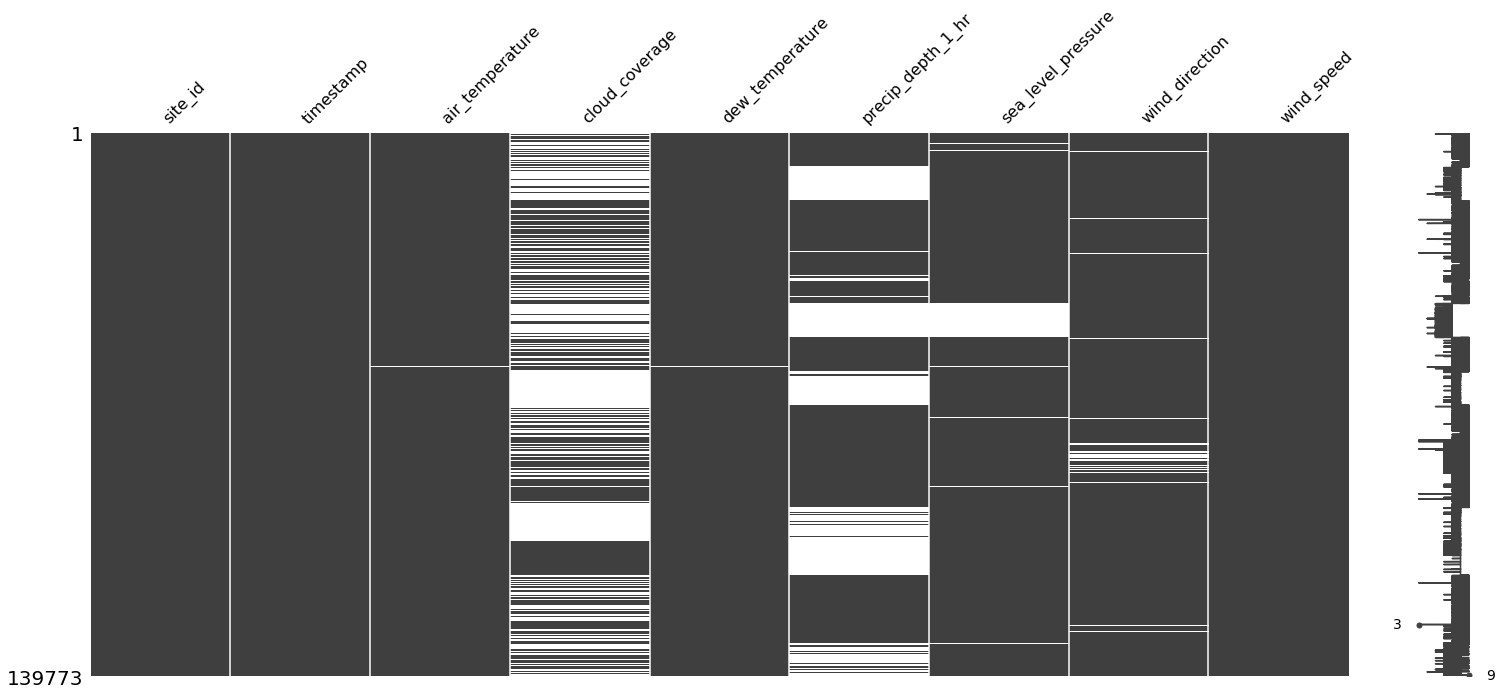

In [5]:
import missingno as msno
msno.matrix(weather_train)

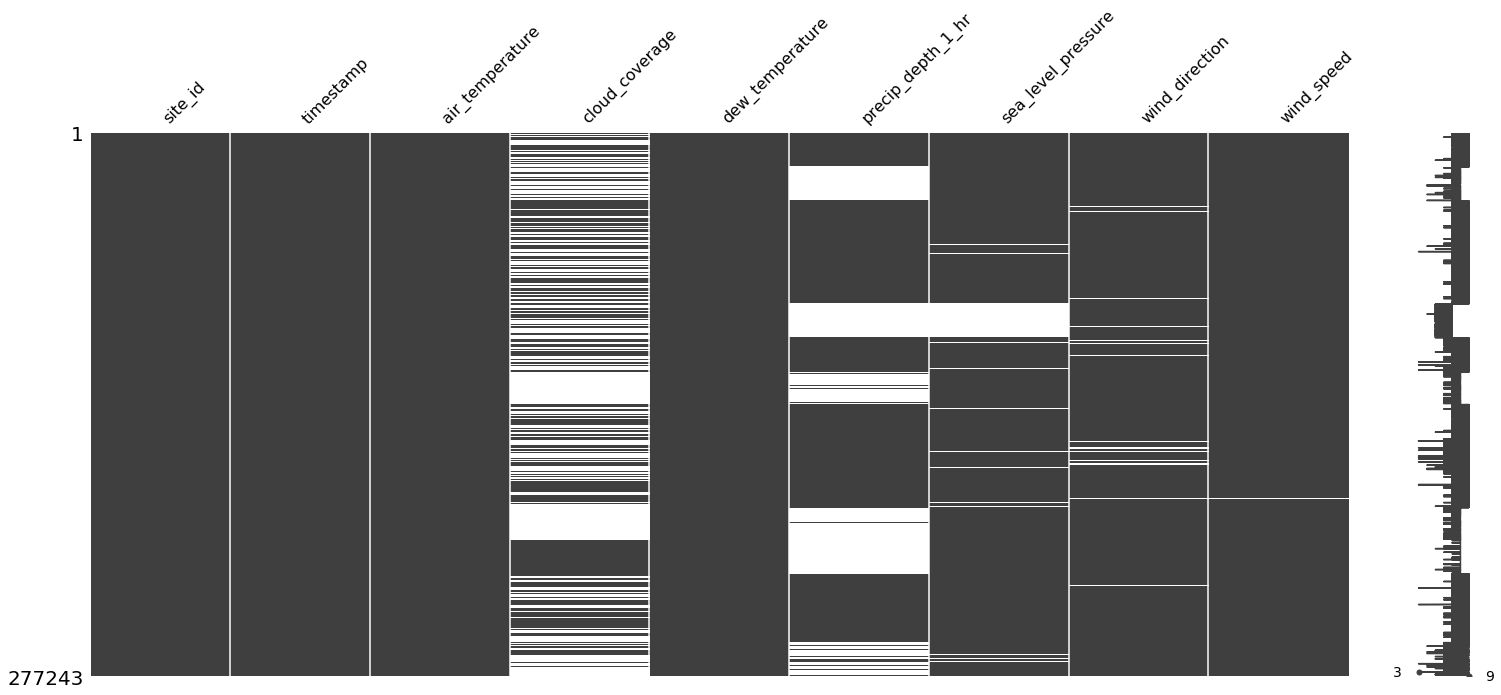

In [6]:
msno.matrix(weather_test)

Fill Null Data as 0

- cloud_coverage
- previp_depth_1_hr
- wind_direction
- wind_speed

Fill Null Data as Mean Value

- sea_level_pressure

In [7]:
features = ['cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'wind_speed']
weather_train[features] = weather_train[features].fillna(0)
weather_test[features] = weather_test[features].fillna(0)
weather_train.head()


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,0.0,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [8]:
mean_value = weather_train['sea_level_pressure'].dropna().sum()/weather_train['sea_level_pressure'].dropna().shape[0]
print(mean_value)
weather_train['sea_level_pressure'] = weather_train['sea_level_pressure'].fillna(mean_value)

1016.1580380163371


## Building

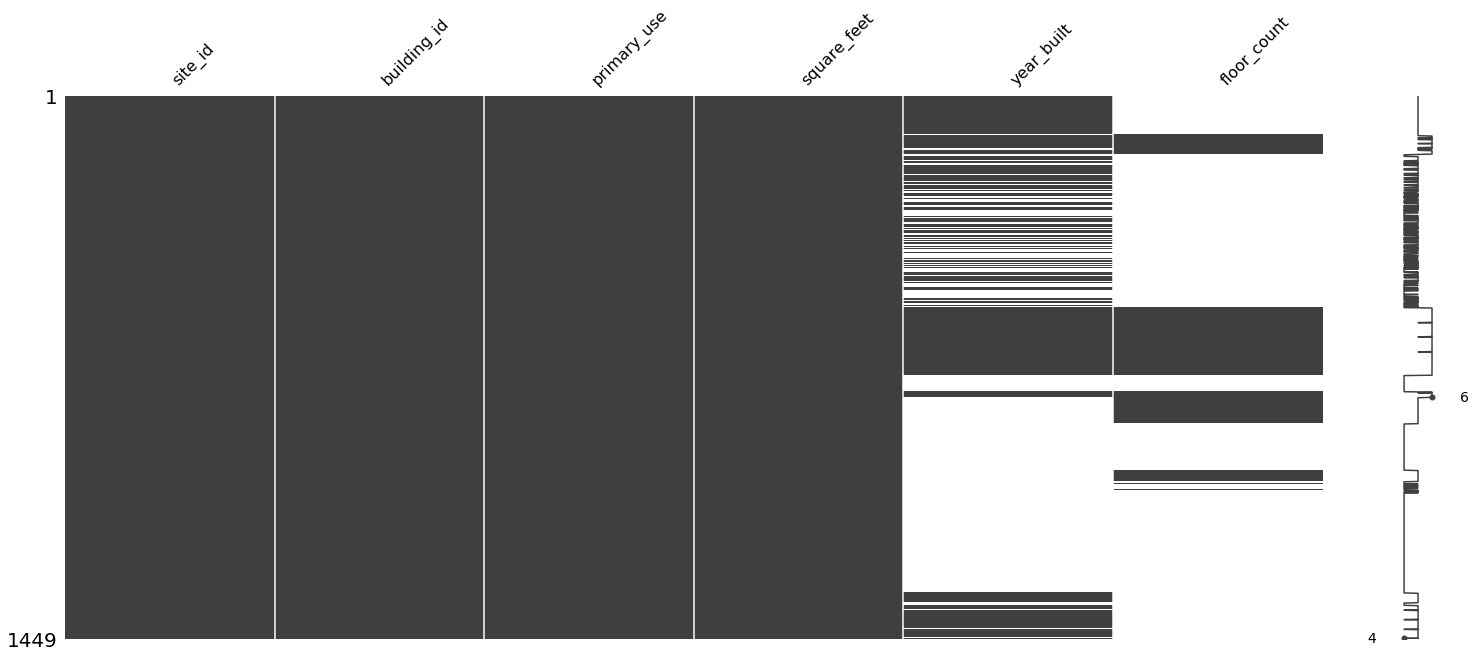

In [9]:
msno.matrix(building_metadata)

In [10]:
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [11]:
building_metadata['site_id'].value_counts()

3     274
13    154
2     135
15    124
9     124
0     105
14    102
4      91
5      89
8      70
1      51
6      44
12     36
10     30
7      15
11      5
Name: site_id, dtype: int64

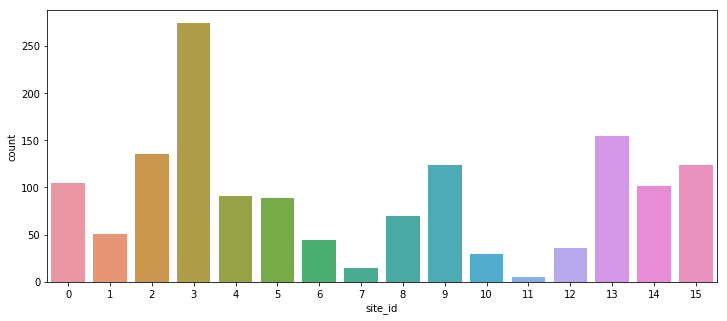

In [12]:
fig, ax = plt.subplots(1,1,figsize=(12, 5))
sns.countplot(building_metadata['site_id'])

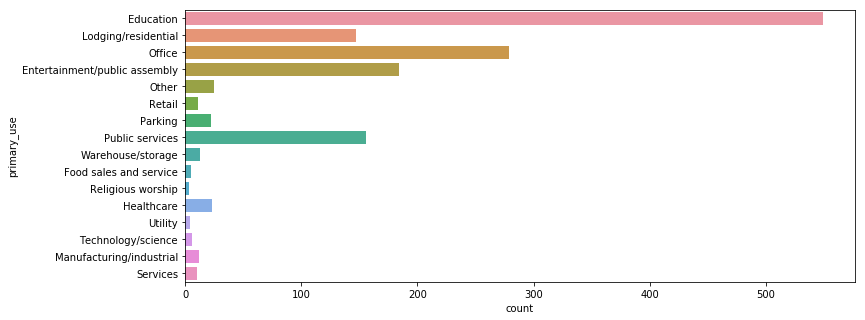

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12, 5))
sns.countplot(y = building_metadata['primary_use'])

## Site Id & Primary Use

In [14]:
%%time
data = list()
for i in building_metadata['primary_use'].unique():
    data.append(go.Bar(name=i, x=building_metadata['site_id'].unique(), y= building_metadata[building_metadata['primary_use']==i]['site_id'].value_counts().sort_index()))

fig = go.Figure(data=data)
fig.update_layout(barmode='stack')
fig.show()

CPU times: user 1.09 s, sys: 131 ms, total: 1.22 s
Wall time: 2.14 s


In [15]:
def building_pie_chart(df, siteid):
    data = df['primary_use'].value_counts()
    fig = go.Figure(data=[go.Pie(values=data, labels=data.index)])
    fig.update_layout(template='plotly_dark', title_text="Building in Site: {}".format(siteid))
    fig.show()

building_pie_chart(building_metadata[building_metadata['site_id']==0],0)

## Wind Direction and Wind Speed 

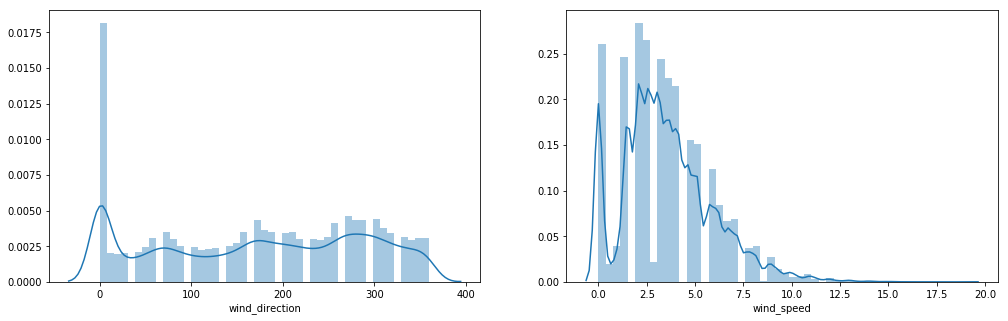

In [16]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
sns.distplot(weather_train['wind_direction'], ax=ax[0])
sns.distplot(weather_train['wind_speed'], ax=ax[1])
plt.show()

In [17]:


def angle_range(st, ed, x):
    if st < ed: ed += 360
    return st <= x.values < ed

def wind_news(df):
    df = df[df['wind_direction'] > 0]
    df['wind_direction'][ df['wind_direction'] < 11.25 ] = df['wind_direction'][ df['wind_direction'] < 11.25 ].apply(lambda x : x+360)
    
    wind_df = pd.DataFrame(columns=['direction', 'speed', 'frequency'])
    angle = [ (i * 22.5 - 11.25 + 360) % 360.0 for i in range(16) ]
    direction = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WMW', 'NW', 'NNW']
    speed = [i*2.5 for i in range(1, 9)]
    tot = 0
    for ang, d  in zip(angle, direction):
        for s in speed:
            cnt = df[(ang <= df['wind_direction'] ) & ( df['wind_direction'] < ang+22.5 )&  (s-2.5 <= df['wind_speed']) & (df['wind_speed'] < s) ].shape[0]
            tot += cnt
            wind_df = wind_df.append({'direction': d, 'speed':s, 'frequency': cnt }, ignore_index=True)
    return wind_df 

In [18]:
def wind_direction_plot(df, title):
    wind = wind_news(df)
    fig = px.bar_polar(wind, r="frequency", theta="direction",
                       color="speed", template="plotly_dark",
                       color_discrete_sequence= px.colors.sequential.Plasma[-2::-1])
    fig.update_layout(title_text='Site ID {}'.format(title))
    fig.show()

In [19]:
wind_direction_plot(weather_train[weather_train['site_id'] == 0], str(0))

## Temperature

In [20]:

def temperature_graph(df):
    df = df.sort_values('timestamp')
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['air_temperature'], name="Air Temperature", line_color='deepskyblue', opacity=0.7))
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['dew_temperature'], name="Dew Temperature", line_color='mediumseagreen', opacity=0.7))
    fig.update_layout(template='plotly_dark', title_text='Time Series with Temperature', xaxis_rangeslider_visible=True)
    fig.show()

In [21]:
temperature_graph(weather_train[weather_train['site_id'] == 0])

## Cloud and Pressure

In [22]:
def cloud_graph(df):
    df = df.sort_values('timestamp')
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['cloud_coverage'], name="Cloud Coverage", line_color='lightskyblue', opacity=0.7))
    fig.update_layout(template='plotly_dark',title_text='Cloud', xaxis_rangeslider_visible=True)
    fig.show()

In [23]:
cloud_graph(weather_train[weather_train['site_id'] == 0])

In [24]:
def pressure_graph(df):
    df = df.sort_values('timestamp')
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['sea_level_pressure'], name="Sea Level Pressure", line_color='royalblue', opacity=0.7))
    fig.update_layout(template='plotly_dark',title_text='Sea Level Pressure', xaxis_rangeslider_visible=True)
    fig.show()


In [25]:
pressure_graph(weather_train[weather_train['site_id'] == 0])

In [26]:
def total_plot(siteid):
    building_pie_chart(building_metadata[building_metadata['site_id']==siteid],str(siteid))
    wind_direction_plot(weather_train[weather_train['site_id'] == siteid], str(siteid))
    temperature_graph(weather_train[weather_train['site_id'] == siteid])
    cloud_graph(weather_train[weather_train['site_id'] == siteid])
    pressure_graph(weather_train[weather_train['site_id'] == siteid])

In [27]:
total_plot(3)